# Variational Autoencoder

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64 
LATENT_DIM = 32

### Preparation of the data 

In [3]:
def map_image(image,label):
    #transformation function for images at the dataset
    image = tf.cast(image,dtype = tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape = (28,28,1,))
    return image

In [4]:
def get_dataset(map_function, validation_set = False):
    if validation_set:
        split_name = 'test'
    else:
        split_name = 'train'
    
    dataset = tfds.load('mnist', as_supervised = True, split = split_name)
    dataset = dataset.map(map_function) # gets transformation function and apply it on dataset
    
    if validation_set:             dataset = dataset.batch(BATCH_SIZE)
    else:                          dataset = dataset.shuffle(1024).batch(BATCH_SIZE)
        
    return dataset

In [5]:
train_set = get_dataset(map_image)
train_set

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### Model 

###### Here is some use cases of Variational Autoencoders

    1. Image generation: VAEs can be used to generate realistic images from a given dataset. By training a VAE on a large dataset of images, it can learn the underlying distribution of the data and generate new images that are similar to the ones in the dataset.

    2. Image compression: VAEs can also be used for image compression. By encoding an image into a lower-dimensional representation using a VAE, it can be compressed without losing too much information. This can be useful for applications where storage or bandwidth is limited.

    3. Anomaly detection: VAEs can be used to detect anomalies in data by reconstructing the input data and comparing it to the original data. If the reconstruction error is high, it could indicate the presence of an anomaly in the data.

    4. Data imputation: VAEs can be used for data imputation, where missing or corrupted data is replaced with estimated values. By training a VAE on a dataset with missing or corrupted data, it can learn to fill in the missing values based on the underlying distribution of the data.

    5. Representation learning: VAEs can be used for representation learning, where the goal is to learn a compact and meaningful representation of the data. By training a VAE to encode and decode the data, the learned representation can capture the most important features of the data.

<img src="images/model.png" style="width:700px;height:400;">

In [6]:
class bottleneck(tf.keras.layers.Layer): #Custom Layer -> z=μ+e0.5σ∗ϵ
    def call(self,inputs):
        #forward pass of bottleneck layer. We dont have such a layer in Keras
        # that's why we should implement one by ourselves
        
        m, s =  inputs 
        
#         print('bottleneck')
#         print('Shape m ',m.shape)
#         print('Shape s ',s.shape)
        
        batch = tf.shape(m)[0]
        dim =   tf.shape(m)[1]
        
        epsilon = tf.keras.backend.random_normal(shape = (batch,dim))
#         print("epsilon shape, ",epsilon.shape)
        
        return m + tf.exp(0.5*s) * epsilon

In [7]:
 def encoder_layers(inputs, latent_dim):
        
        
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encoder_conv_layer1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encoder_conv_layer2")(x)
#     print('this is x1 shape ',x.shape)
    #we will need shape of the this batch to reconstruct the latent vector to the 2 dimension for upsampling 
    needed_batch = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Flatten(name="encode_flatten")(needed_batch)
    x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
#     print('encoder_layer')
    m = tf.keras.layers.Dense(latent_dim, name = 'latent_vector_m')(x)
#     print('Shape m ',m.shape)
    s = tf.keras.layers.Dense(latent_dim, name = "latent_vector_s")(x)
#     print('Shape s ',s.shape)
    return m,s, needed_batch.shape
    

In [8]:
#TEST Encoder layer and bottleneck

mock_data = tf.random.uniform(
    (1,28, 28, 1),
    minval=0,
    maxval=255,
    dtype=tf.dtypes.float32,
)
encoder_layers_tests = encoder_layers(mock_data,32)
encoder_layers_tests[0].shape,encoder_layers_tests[1].shape,tf.shape(encoder_layers_tests[2])

(TensorShape([1, 32]),
 TensorShape([1, 32]),
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>)

In [9]:
def encoder_model(latent_dim, input_shape):
    
    inpts = tf.keras.layers.Input(shape = input_shape)
    
    m,s,conv_shape = encoder_layers(inpts, latent_dim = LATENT_DIM)

    z = bottleneck()((m,s))
    
    model = tf.keras.Model(inpts, outputs = [m,s,z])
    
    return model, conv_shape
    
    
    

In [10]:
encoder1 = encoder_model(32,(28, 28, 1))[0]
# type(encoder1)
encoder1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_layer1 (Conv2D)   (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 14, 14, 32)  128         ['encoder_conv_layer1[0][0]']    
 rmalization)                                                                                     
                                                                                                  
 encoder_conv_layer2 (Conv2D)   (None, 7, 7, 64)     18496       ['batch_normalization_3[0][0]

In [11]:
def decoder_layers(inpts,conv_shape):

    units = conv_shape[1]* conv_shape[2]* conv_shape[3]
    x = tf.keras.layers.Dense(units, activation = 'relu',name='decode_dense1')(inpts)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]) , name = 'reconstruction_of_conv')(x)
    
     # upsampling 
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)
    
    return x


In [12]:
def decoder_model(latent_dim,conv_shape):
    
    inputs = tf.keras.layers.Input(shape=(latent_dim,))
    
    outputs = decoder_layers(inputs,conv_shape)
    
    model = tf.keras.Model(inputs,outputs)
    
    return model

In [13]:
# decoder model test

decoder_test = decoder_model(LATENT_DIM,conv_shape = (None,7,7,64))
decoder_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 decode_dense1 (Dense)       (None, 3136)              103488    
                                                                 
 batch_normalization_6 (Batc  (None, 3136)             12544     
 hNormalization)                                                 
                                                                 
 reconstruction_of_conv (Res  (None, 7, 7, 64)         0         
 hape)                                                           
                                                                 
 decode_conv2d_2 (Conv2DTran  (None, 14, 14, 64)       36928     
 spose)                                                          
                                                           

In [14]:
#Kullback–Leibler Divergence 
def kl_reconstruction_loss(inputs, outputs, m, s):
    kl_loss = 1 + s - tf.square(m) - tf.math.exp(s)
    kl_loss = tf.reduce_mean(kl_loss) *  (-0.5)
    
    return kl_loss

In [15]:
def VAE_model(encoder,decoder,input_shape):
    
    inputs = tf.keras.layers.Input(shape = input_shape)
    
    m,s,z =  encoder(inputs)
    
    reconstruction = decoder(z)
    
    model = tf.keras.Model(inputs = inputs, outputs = reconstruction)
    
    loss = kl_reconstruction_loss(inputs,z,m,s)
    model.add_loss(loss)
    
    return model

In [16]:
def get_models(input_shape, latent_dim):
    encoder, conv_shape = encoder_model(latent_dim = latent_dim, input_shape = input_shape)
    decoder = decoder_model(latent_dim = latent_dim, conv_shape = conv_shape)
    VAE = VAE_model(encoder,decoder,input_shape = input_shape)
    
    return encoder,decoder, VAE

In [17]:
encoder,decoder,VAE = get_models(input_shape= (28,28,1), latent_dim = LATENT_DIM)

In [18]:
VAE.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           [(None, 32),         83364       ['input_5[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 model_3 (Functional)           (None, 28, 28, 1)    172097      ['model_2[0][2]']                
                                                                                            

### Loading the dataset

In [19]:
def map_image(image, label):
    '''returns a normalized and reshaped tensor from a given image'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape=(28, 28, 1,))
    
    return image


def get_dataset(map_fn, is_validation=False):
    '''Loads and prepares the mnist dataset from TFDS.'''
    if is_validation:
        split_name = "test"
    else:
        split_name = "train"
    dataset = tfds.load('mnist', as_supervised=True, split=split_name)
    dataset = dataset.map(map_fn)
    
    if is_validation:
        dataset = dataset.batch(BATCH_SIZE)
    else:
        dataset = dataset.shuffle(1024).batch(BATCH_SIZE)
    return dataset

In [20]:
train_dataset = get_dataset(map_image)

### Helper functions

In [21]:
def generate_and_save_images(model, epoch, step, test_input):
    """Helper function to plot our 16 images"""
    # generate images from the test input
    predictions = model.predict(test_input)
    # plot the results
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    # tight_layout minimizes the overlap between 2 sub-plots
    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
#     plt.savefig('images/image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
    plt.show()

### Train Loop

In [22]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [41]:
# number of epochs
epochs = 10

    We will feed random latent vector for generating new images

1/1 [==============================] - 0s 48ms/step


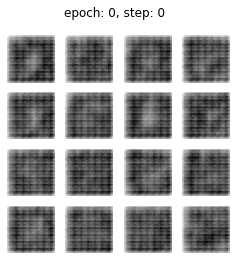

Start of epoch 0
Epoch: 0 step: 0 mean loss = 454.7945
1/1 [==============================] - 0s 48ms/step


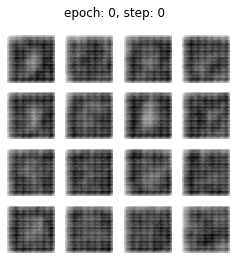

Epoch: 0 step: 100 mean loss = 239.68863
1/1 [==============================] - 0s 57ms/step


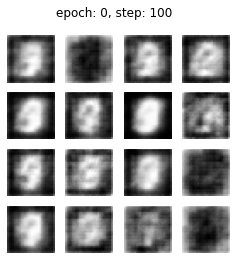

Epoch: 0 step: 200 mean loss = 211.80043
1/1 [==============================] - 0s 48ms/step


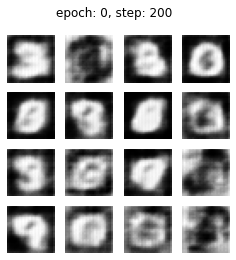

Epoch: 0 step: 300 mean loss = 189.8601
1/1 [==============================] - 0s 48ms/step


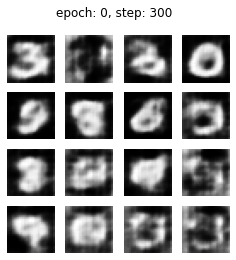

Epoch: 0 step: 400 mean loss = 173.6423
1/1 [==============================] - 0s 48ms/step


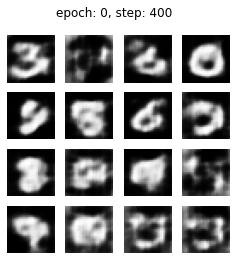

Epoch: 0 step: 500 mean loss = 161.62979
1/1 [==============================] - 0s 48ms/step


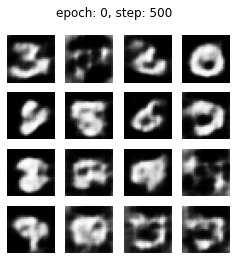

Epoch: 0 step: 600 mean loss = 152.773
1/1 [==============================] - 0s 49ms/step


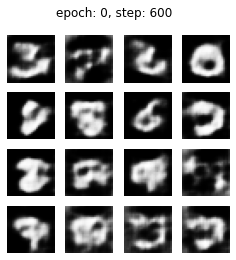

Epoch: 0 step: 700 mean loss = 145.90968
1/1 [==============================] - 0s 48ms/step


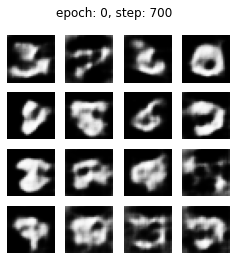

Epoch: 0 step: 800 mean loss = 140.23589
1/1 [==============================] - 0s 50ms/step


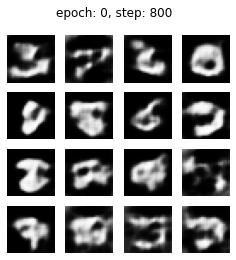

Epoch: 0 step: 900 mean loss = 135.50734
1/1 [==============================] - 0s 47ms/step


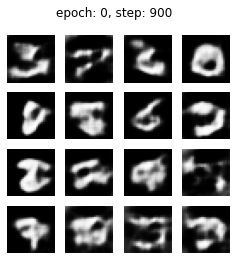

Start of epoch 1
Epoch: 1 step: 0 mean loss = 133.8768
1/1 [==============================] - 0s 49ms/step


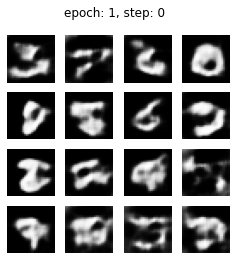

Epoch: 1 step: 100 mean loss = 130.02303
1/1 [==============================] - 0s 48ms/step


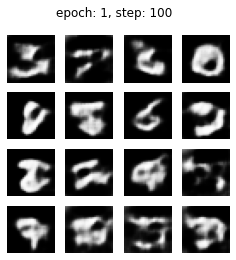

Epoch: 1 step: 200 mean loss = 126.714935
1/1 [==============================] - 0s 48ms/step


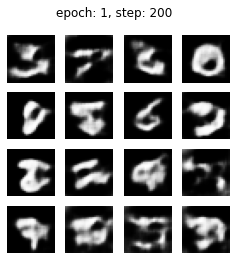

Epoch: 1 step: 300 mean loss = 123.77111
1/1 [==============================] - 0s 49ms/step


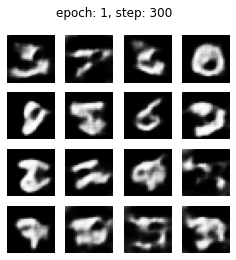

Epoch: 1 step: 400 mean loss = 121.266365
1/1 [==============================] - 0s 49ms/step


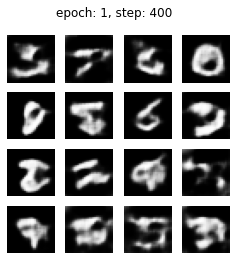

Epoch: 1 step: 500 mean loss = 119.02553
1/1 [==============================] - 0s 50ms/step


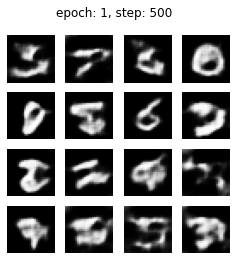

Epoch: 1 step: 600 mean loss = 117.01577
1/1 [==============================] - 0s 47ms/step


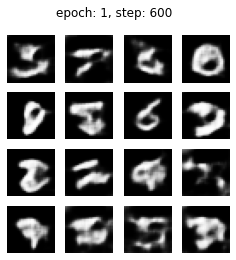

Epoch: 1 step: 700 mean loss = 115.27349
1/1 [==============================] - 0s 48ms/step


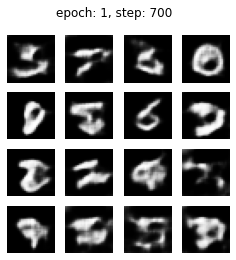

Epoch: 1 step: 800 mean loss = 113.67183
1/1 [==============================] - 0s 48ms/step


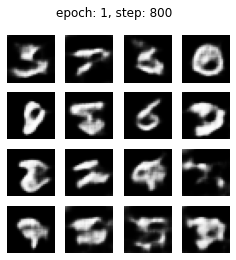

Epoch: 1 step: 900 mean loss = 112.238205
1/1 [==============================] - 0s 47ms/step


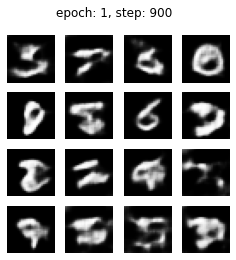

Start of epoch 2
Epoch: 2 step: 0 mean loss = 111.71784
1/1 [==============================] - 0s 49ms/step


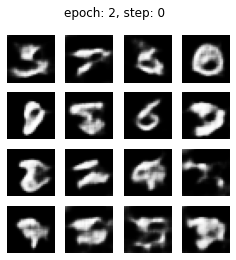

Epoch: 2 step: 100 mean loss = 110.441574
1/1 [==============================] - 0s 49ms/step


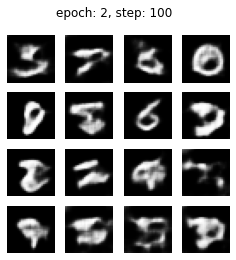

Epoch: 2 step: 200 mean loss = 109.24097
1/1 [==============================] - 0s 48ms/step


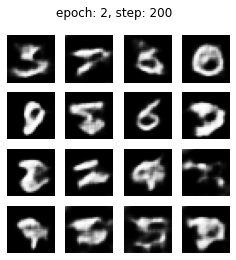

Epoch: 2 step: 300 mean loss = 108.11117
1/1 [==============================] - 0s 46ms/step


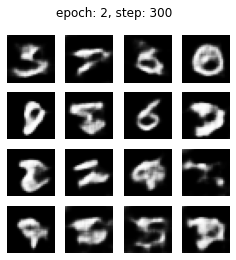

Epoch: 2 step: 400 mean loss = 107.08579
1/1 [==============================] - 0s 48ms/step


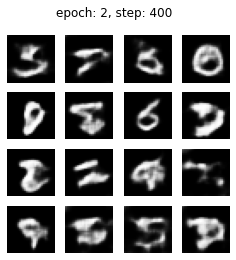

Epoch: 2 step: 500 mean loss = 106.146736
1/1 [==============================] - 0s 48ms/step


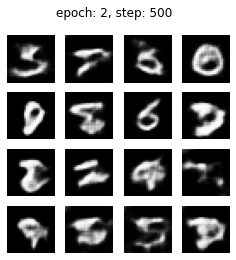

Epoch: 2 step: 600 mean loss = 105.24809
1/1 [==============================] - 0s 46ms/step


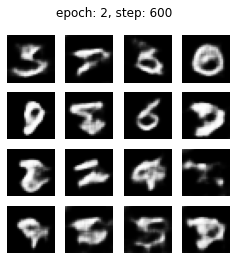

Epoch: 2 step: 700 mean loss = 104.44741
1/1 [==============================] - 0s 50ms/step


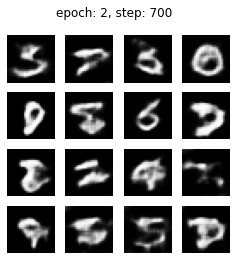

Epoch: 2 step: 800 mean loss = 103.68699
1/1 [==============================] - 0s 48ms/step


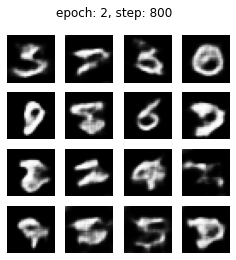

Epoch: 2 step: 900 mean loss = 102.974884
1/1 [==============================] - 0s 49ms/step


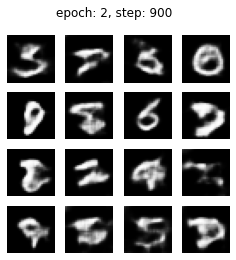

Start of epoch 3
Epoch: 3 step: 0 mean loss = 102.71093
1/1 [==============================] - 0s 48ms/step


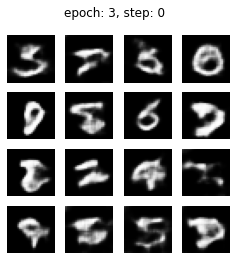

Epoch: 3 step: 100 mean loss = 102.05602
1/1 [==============================] - 0s 51ms/step


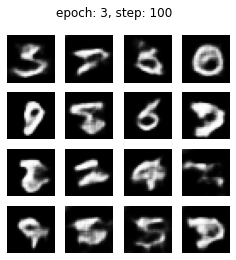

Epoch: 3 step: 200 mean loss = 101.428375
1/1 [==============================] - 0s 56ms/step


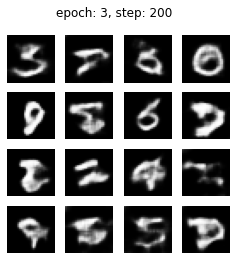

Epoch: 3 step: 300 mean loss = 100.801544
1/1 [==============================] - 0s 48ms/step


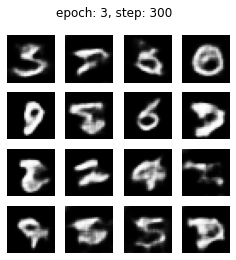

Epoch: 3 step: 400 mean loss = 100.229355
1/1 [==============================] - 0s 48ms/step


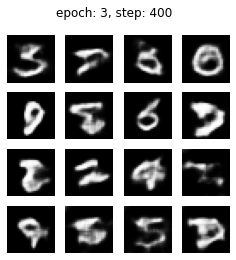

Epoch: 3 step: 500 mean loss = 99.68816
1/1 [==============================] - 0s 28ms/step


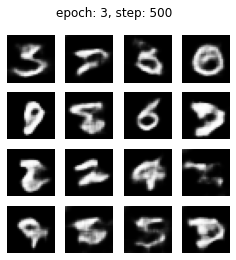

Epoch: 3 step: 600 mean loss = 99.16501
1/1 [==============================] - 0s 29ms/step


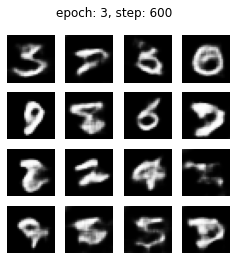

Epoch: 3 step: 700 mean loss = 98.69604
1/1 [==============================] - 0s 29ms/step


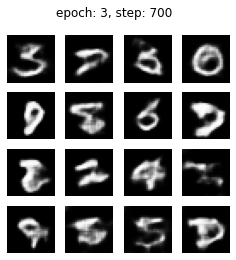

Epoch: 3 step: 800 mean loss = 98.23448
1/1 [==============================] - 0s 31ms/step


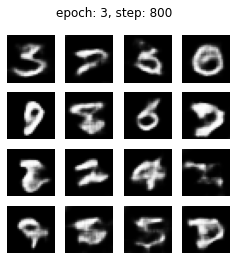

Epoch: 3 step: 900 mean loss = 97.804855
1/1 [==============================] - 0s 28ms/step


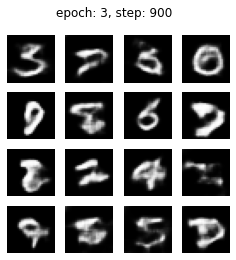

Start of epoch 4
Epoch: 4 step: 0 mean loss = 97.6364
1/1 [==============================] - 0s 29ms/step


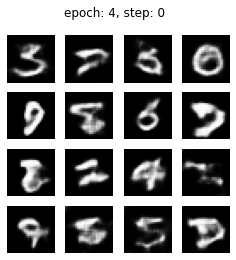

Epoch: 4 step: 100 mean loss = 97.22554
1/1 [==============================] - 0s 27ms/step


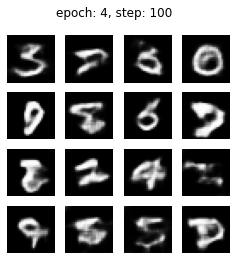

Epoch: 4 step: 200 mean loss = 96.82285
1/1 [==============================] - 0s 31ms/step


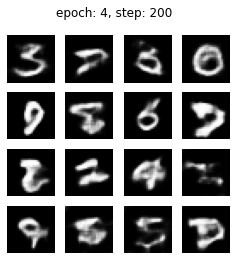

Epoch: 4 step: 300 mean loss = 96.41226
1/1 [==============================] - 0s 28ms/step


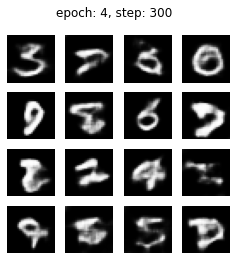

Epoch: 4 step: 400 mean loss = 96.05461
1/1 [==============================] - 0s 28ms/step


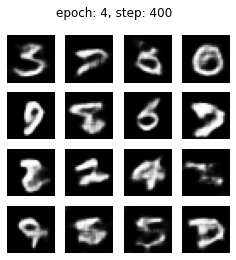

Epoch: 4 step: 500 mean loss = 95.69633
1/1 [==============================] - 0s 31ms/step


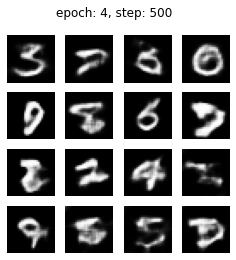

Epoch: 4 step: 600 mean loss = 95.34737
1/1 [==============================] - 0s 29ms/step


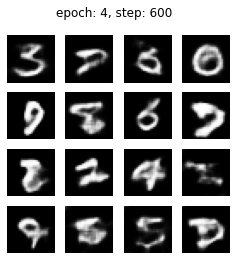

Epoch: 4 step: 700 mean loss = 95.03304
1/1 [==============================] - 0s 30ms/step


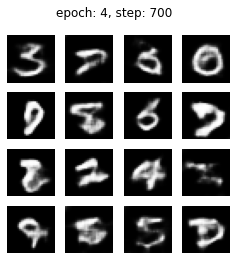

Epoch: 4 step: 800 mean loss = 94.72386
1/1 [==============================] - 0s 30ms/step


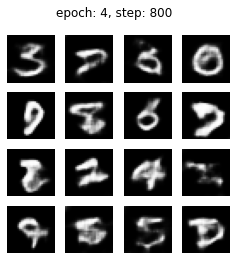

Epoch: 4 step: 900 mean loss = 94.41922
1/1 [==============================] - 0s 29ms/step


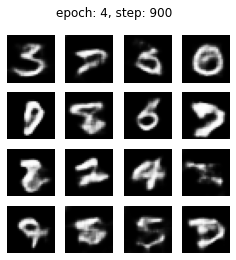

Start of epoch 5
Epoch: 5 step: 0 mean loss = 94.306625
1/1 [==============================] - 0s 30ms/step


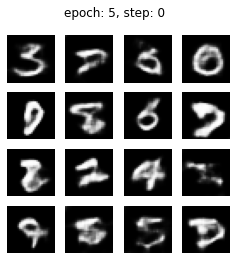

Epoch: 5 step: 100 mean loss = 94.02333
1/1 [==============================] - 0s 29ms/step


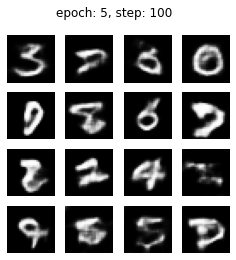

Epoch: 5 step: 200 mean loss = 93.7374
1/1 [==============================] - 0s 30ms/step


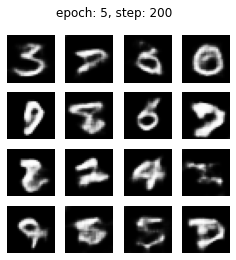

Epoch: 5 step: 300 mean loss = 93.447495
1/1 [==============================] - 0s 27ms/step


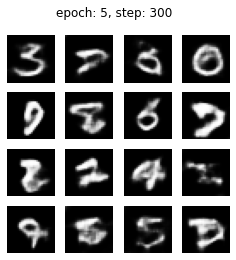

Epoch: 5 step: 400 mean loss = 93.18142
1/1 [==============================] - 0s 31ms/step


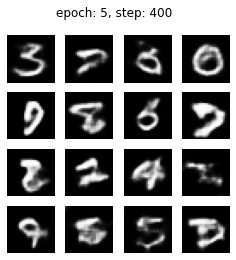

Epoch: 5 step: 500 mean loss = 92.929756
1/1 [==============================] - 0s 29ms/step


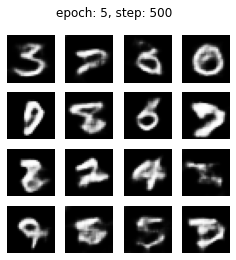

Epoch: 5 step: 600 mean loss = 92.67211
1/1 [==============================] - 0s 37ms/step


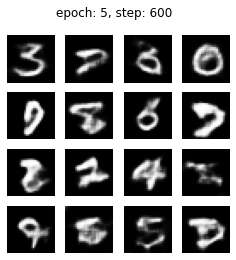

Epoch: 5 step: 700 mean loss = 92.44231
1/1 [==============================] - 0s 32ms/step


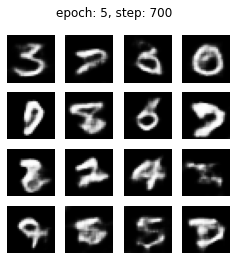

Epoch: 5 step: 800 mean loss = 92.20897
1/1 [==============================] - 0s 32ms/step


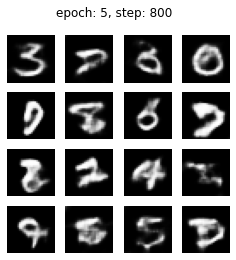

Epoch: 5 step: 900 mean loss = 91.99596
1/1 [==============================] - 0s 31ms/step


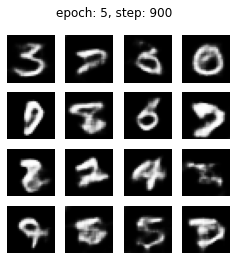

Start of epoch 6
Epoch: 6 step: 0 mean loss = 91.91246
1/1 [==============================] - 0s 32ms/step


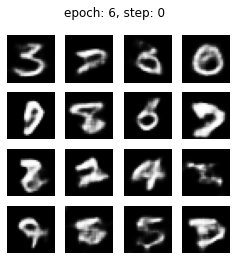

Epoch: 6 step: 100 mean loss = 91.69693
1/1 [==============================] - 0s 30ms/step


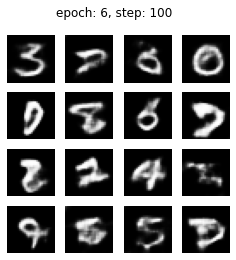

Epoch: 6 step: 200 mean loss = 91.48428
1/1 [==============================] - 0s 29ms/step


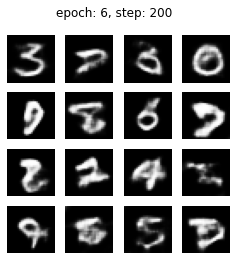

Epoch: 6 step: 300 mean loss = 91.26928
1/1 [==============================] - 0s 31ms/step


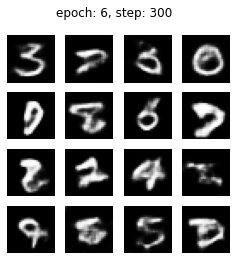

Epoch: 6 step: 400 mean loss = 91.06369
1/1 [==============================] - 0s 32ms/step


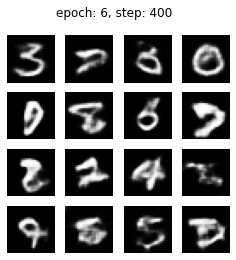

Epoch: 6 step: 500 mean loss = 90.86489
1/1 [==============================] - 0s 31ms/step


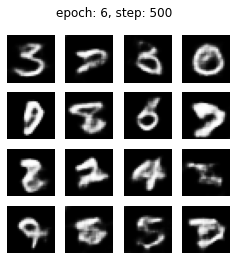

Epoch: 6 step: 600 mean loss = 90.67401
1/1 [==============================] - 0s 32ms/step


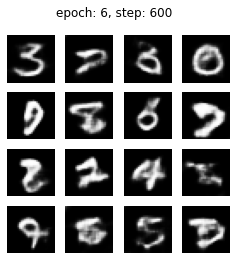

Epoch: 6 step: 700 mean loss = 90.496796
1/1 [==============================] - 0s 32ms/step


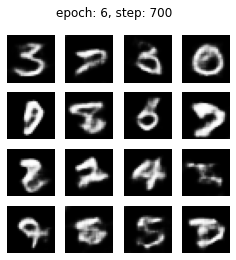

Epoch: 6 step: 800 mean loss = 90.31963
1/1 [==============================] - 0s 32ms/step


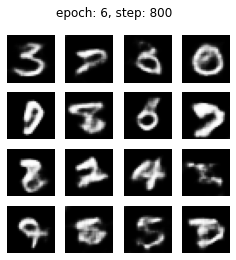

Epoch: 6 step: 900 mean loss = 90.1447
1/1 [==============================] - 0s 30ms/step


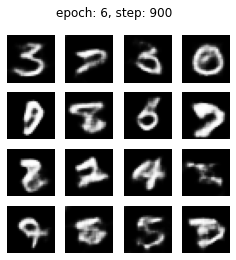

Start of epoch 7
Epoch: 7 step: 0 mean loss = 90.08242
1/1 [==============================] - 0s 33ms/step


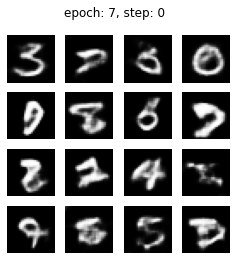

Epoch: 7 step: 100 mean loss = 89.91728
1/1 [==============================] - 0s 32ms/step


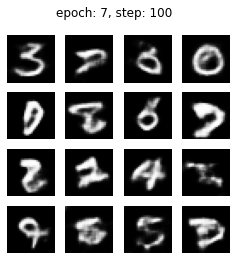

Epoch: 7 step: 200 mean loss = 89.74655
1/1 [==============================] - 0s 31ms/step


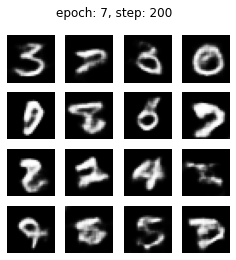

Epoch: 7 step: 300 mean loss = 89.572174
1/1 [==============================] - 0s 30ms/step


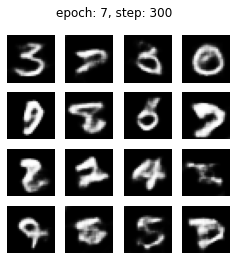

Epoch: 7 step: 400 mean loss = 89.415146
1/1 [==============================] - 0s 34ms/step


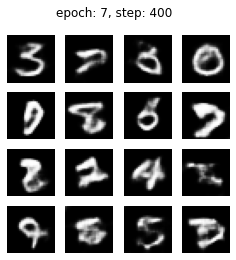

Epoch: 7 step: 500 mean loss = 89.25996
1/1 [==============================] - 0s 30ms/step


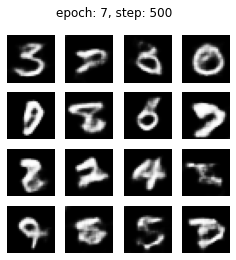

Epoch: 7 step: 600 mean loss = 89.10429
1/1 [==============================] - 0s 31ms/step


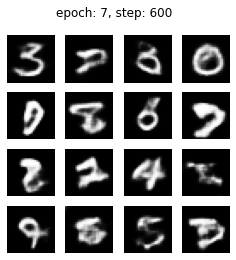

Epoch: 7 step: 700 mean loss = 88.96383
1/1 [==============================] - 0s 32ms/step


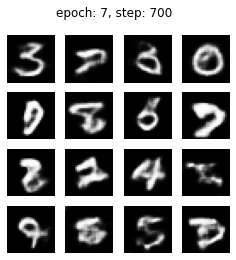

Epoch: 7 step: 800 mean loss = 88.82145
1/1 [==============================] - 0s 29ms/step


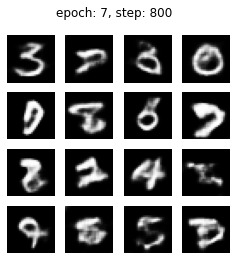

Epoch: 7 step: 900 mean loss = 88.685356
1/1 [==============================] - 0s 29ms/step


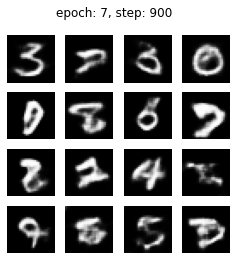

Start of epoch 8
Epoch: 8 step: 0 mean loss = 88.63038
1/1 [==============================] - 0s 32ms/step


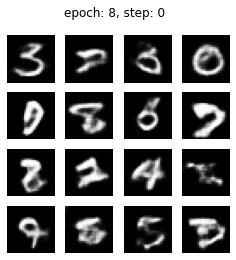

Epoch: 8 step: 100 mean loss = 88.49579
1/1 [==============================] - 0s 30ms/step


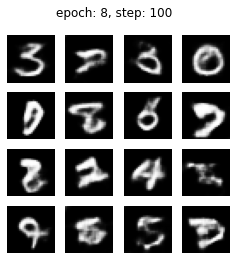

Epoch: 8 step: 200 mean loss = 88.36019
1/1 [==============================] - 0s 30ms/step


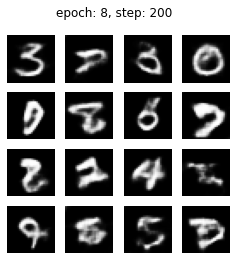

Epoch: 8 step: 300 mean loss = 88.22036
1/1 [==============================] - 0s 31ms/step


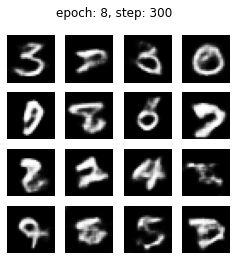

Epoch: 8 step: 400 mean loss = 88.09046
1/1 [==============================] - 0s 31ms/step


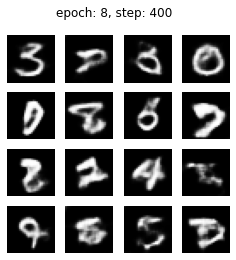

Epoch: 8 step: 500 mean loss = 87.96233
1/1 [==============================] - 0s 34ms/step


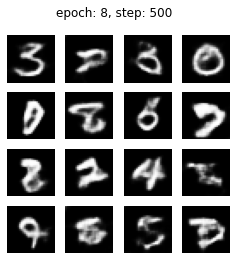

Epoch: 8 step: 600 mean loss = 87.8365
1/1 [==============================] - 0s 40ms/step


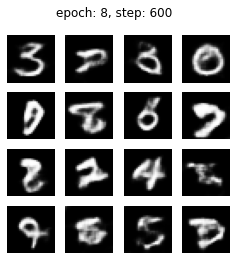

Epoch: 8 step: 700 mean loss = 87.71695
1/1 [==============================] - 0s 31ms/step


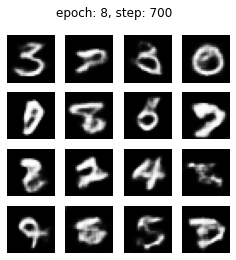

Epoch: 8 step: 800 mean loss = 87.60046
1/1 [==============================] - 0s 30ms/step


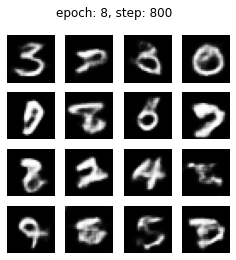

Epoch: 8 step: 900 mean loss = 87.48737
1/1 [==============================] - 0s 29ms/step


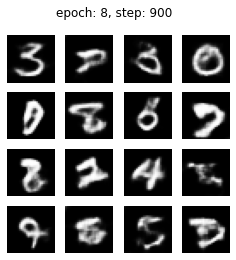

Start of epoch 9
Epoch: 9 step: 0 mean loss = 87.44476
1/1 [==============================] - 0s 31ms/step


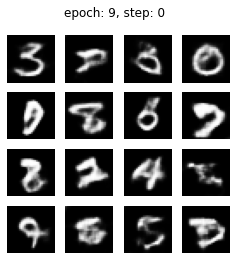

Epoch: 9 step: 100 mean loss = 87.33427
1/1 [==============================] - 0s 31ms/step


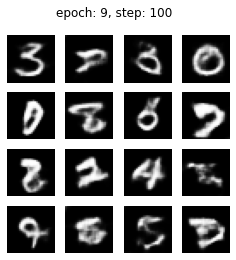

Epoch: 9 step: 200 mean loss = 87.220436
1/1 [==============================] - 0s 33ms/step


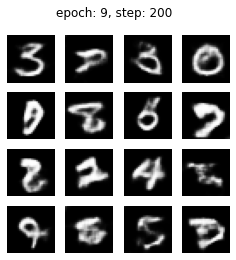

Epoch: 9 step: 300 mean loss = 87.09979
1/1 [==============================] - 0s 30ms/step


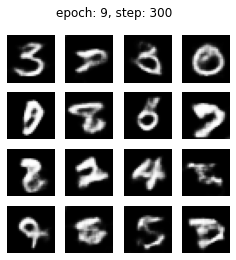

Epoch: 9 step: 400 mean loss = 86.99335
1/1 [==============================] - 0s 32ms/step


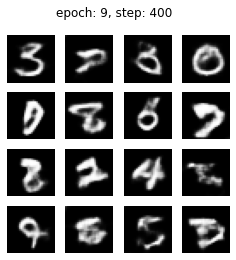

Epoch: 9 step: 500 mean loss = 86.88641
1/1 [==============================] - 0s 33ms/step


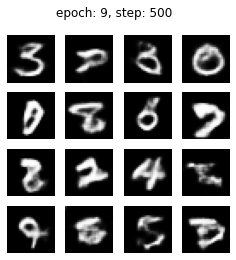

Epoch: 9 step: 600 mean loss = 86.78152
1/1 [==============================] - 0s 32ms/step


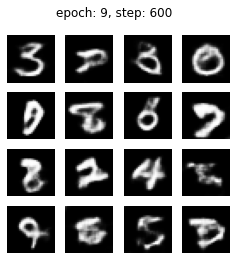

Epoch: 9 step: 700 mean loss = 86.68029
1/1 [==============================] - 0s 31ms/step


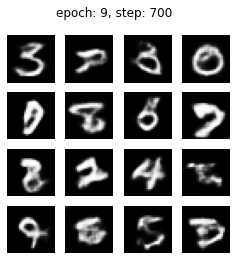

Epoch: 9 step: 800 mean loss = 86.5845
1/1 [==============================] - 0s 31ms/step


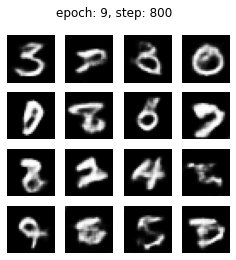

Epoch: 9 step: 900 mean loss = 86.48686
1/1 [==============================] - 0s 32ms/step


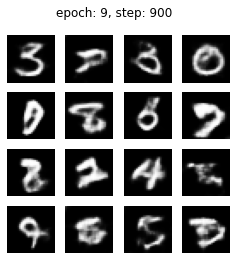

In [42]:
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

generate_and_save_images(decoder, 0, 0, random_vector_for_generation)



for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    
    
    
  # iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # feed a batch to the VAE model
            reconstructed = VAE(x_batch_train)
            # compute reconstruction loss
            flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784
            
            # add KLD regularization loss
            loss += sum(VAE.losses)  
        # get the gradients and update the weights
        grads = tape.gradient(loss, VAE.trainable_weights)
        optimizer.apply_gradients(zip(grads, VAE.trainable_weights))
        # compute the loss metric
        loss_metric(loss)
        # display outputs every 100 steps
        if step % 100 == 0:
        #     display.clear_output(wait=False)    
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)

    I have stopped training of the model at 10 epoches 

### Helper functions


In [43]:
def tensor_to_image(tensor):
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 


def imshow(image, title=None):
    '''displays an image with a corresponding title'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        print(image.shape)
    
    plt.imshow(image, cmap = 'gray')
    if title:
        plt.title(title)

### Model test
    
    As we have already seen in the training cell, model is able to generate the new data. In the cell below I want to check its smoothing and noise cancelation ability. Note that this model not exactly designed for noise cancelation

In [31]:
def image_squeezed(image):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    return image

In [51]:
def plot_comparement(VAE, image):
    generated_image = VAE(image)


    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    ax[0].imshow(image_squeezed(image),cmap='gray')
    ax[0].set_title('Input image')

    ax[1].imshow(image_squeezed(generated_image),cmap='gray')
    ax[1].set_title('Generated image')

    plt.show()

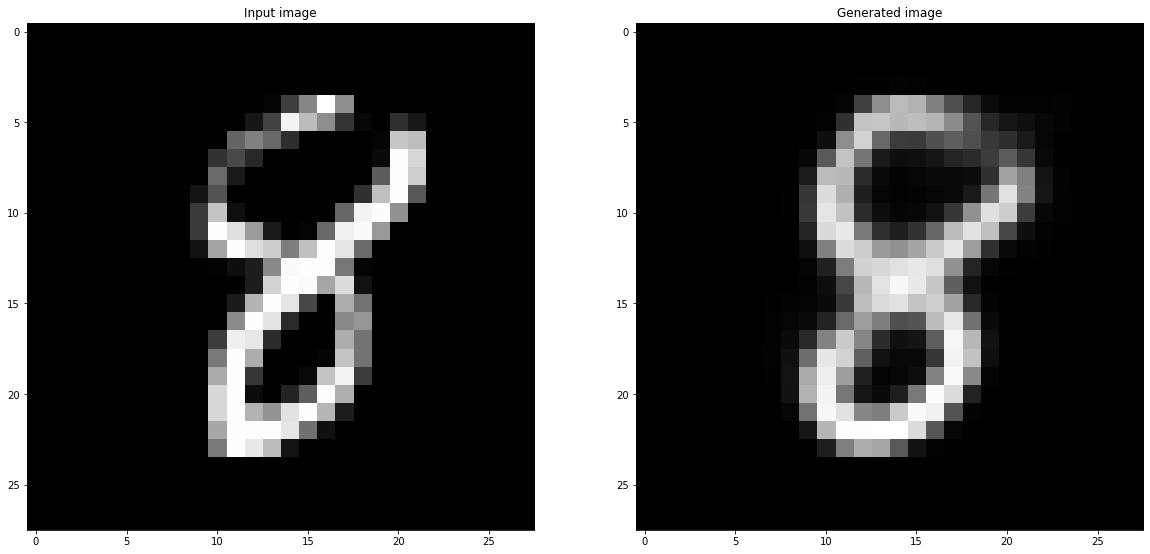

In [52]:
image = next(iter(train_dataset.take(1)))[0]
image = tf.expand_dims(image,axis=0)

### Adding noise on image to check whether model will decrease noise or not 

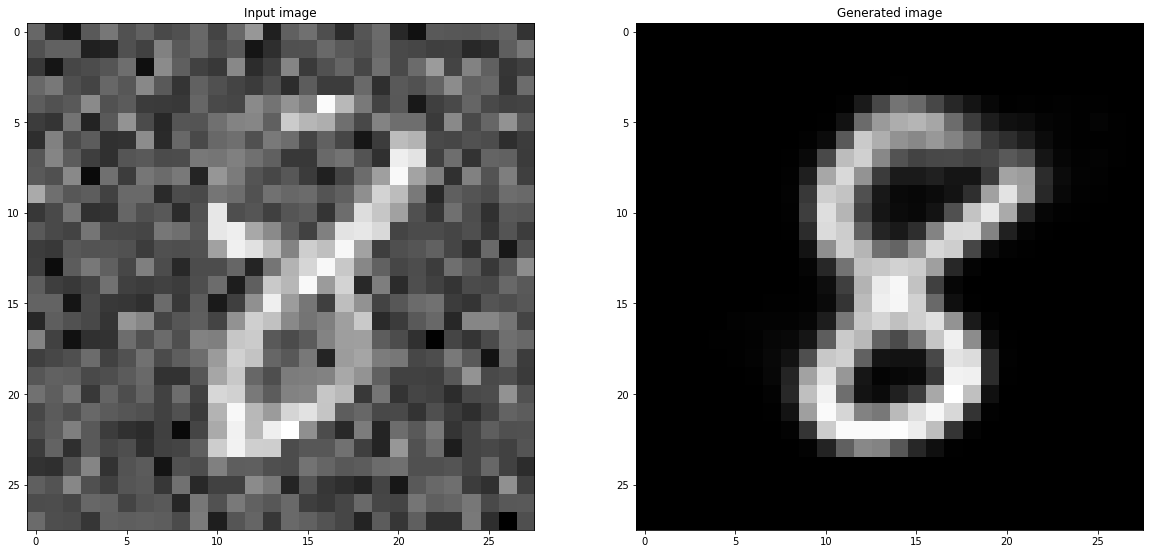

In [60]:
noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=0.2)
noisy_image = image + noise

plot_comparement(VAE,noisy_image)